In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker


from matplotlib import style, cm
from sklearn.linear_model import LinearRegression
import matplotlib.ticker
from scipy.optimize import curve_fit
import nasdaqdatalink



In [31]:
plt.rcParams['figure.figsize'] = [14, 8]

In [2]:
btc_data = nasdaqdatalink.get("BCHAIN/MKPRU")
print(btc_data)

               Value
Date                
2009-01-02      0.00
2009-01-03      0.00
2009-01-04      0.00
2009-01-05      0.00
2009-01-06      0.00
...              ...
2022-04-28  39249.28
2022-04-29  39770.04
2022-04-30  38596.28
2022-05-01  37661.19
2022-05-02  38475.48

[4869 rows x 1 columns]


In [21]:
df = btc_data.reset_index()
df = df[::-1]
df

,Date,Value
4868,2022-05-02,38475.48
4867,2022-05-01,37661.19
4866,2022-04-30,38596.28
4865,2022-04-29,39770.04
4864,2022-04-28,39249.28
...,...,...
4,2009-01-06,0.00
3,2009-01-05,0.00
2,2009-01-04,0.00
1,2009-01-03,0.00


In [22]:
#need to reverse the data later onddd
#remove entries where price is 0
df = df[df["Value"] > 0]
#convert Date to date format
df

,Date,Value
4868,2022-05-02,38475.4800
4867,2022-05-01,37661.1900
4866,2022-04-30,38596.2800
4865,2022-04-29,39770.0400
4864,2022-04-28,39249.2800
...,...,...
596,2010-08-21,0.0664
595,2010-08-20,0.0700
594,2010-08-19,0.0667
593,2010-08-18,0.0688


In [25]:
df["Date"] = pd.to_datetime(df["Date"])
df=df.reset_index()
df.drop("index", axis=1, inplace=True)
df = df.iloc[::-1]
df

,Date,Value
4276,2010-08-16,0.0769
4275,2010-08-18,0.0688
4274,2010-08-19,0.0667
4273,2010-08-20,0.0700
4272,2010-08-21,0.0664
...,...,...
4,2022-04-28,39249.2800
3,2022-04-29,39770.0400
2,2022-04-30,38596.2800
1,2022-05-01,37661.1900


In [26]:
#this is the function we want to fit over our data: a.log(x)+b
#we need to find appropriate coefficients
def func(x, p1, p2):
    return p1*np.log(x) + p2

In [27]:
#we are fitting log of price of BTC against the function, not actual price
ydata = np.log(df["Value"])
xdata = [x+1 for x in range(len(df))] #just use numbers for dates

extended_dates = pd.date_range(df["Date"].iloc[0], "2023-01-01")

#extract optimal coefficients using curve fit
popt, pcov = curve_fit(func, xdata, ydata, p0=(3.0, -10))
#try to get ydata from xdata and function
#popt has coefficients, pcov has covariances between them
print(popt)

[  3.10067478 -16.46569398]


In [28]:
#generate fitted Y data
fittedYdata = func(np.array([x+1 for x in range(len(df))]), popt[0], popt[1])#pass values to function
fittedYdataExtended = func(np.array([x+1 for x in range(len(extended_dates))]), popt[0], popt[1])

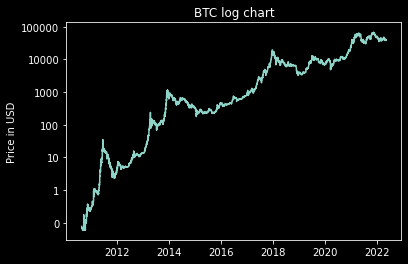

In [29]:
plt.style.use("dark_background")
fig, ax = plt.subplots()
ax.semilogy(df["Date"], df["Value"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.title("BTC log chart")
plt.ylabel("Price in USD")
plt.show()

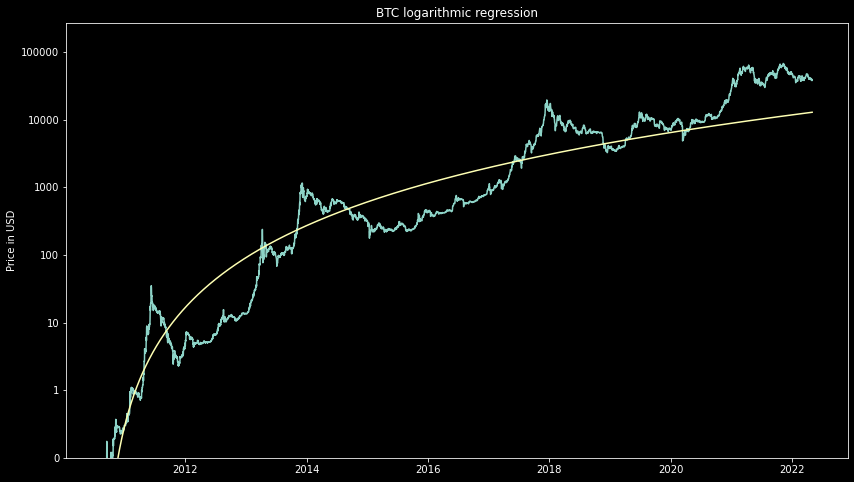

In [32]:
plt.style.use("dark_background")
fig, ax = plt.subplots()
ax.semilogy(df["Date"], df["Value"])
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(df["Date"], np.exp(fittedYdata))

plt.title("BTC logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
plt.show()

### Edit: adding part for calculating correlation coefficient for non - bubble data

In [33]:
from sklearn.linear_model import LinearRegression
def get_furthest_x(y, line):
    #y is all the log of values 
    # line is the linear regression line
    difference = [abs(y[x] - line[x]) for x in range(len(line))]
    max_difference = max(difference)
    return difference.index(max_difference)

df["ind"] = [x+1 for x in range(len(df))]
#df = df[df.Date >= "2010-09-16"]
def perform_regression(df):
    X = np.array(np.log(df.ind)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
    y = np.array(np.log(df.Value))

    #now X and y are how they look on a log-log chart
    reg = LinearRegression().fit(X,y)

    #remember plt plots on a linear axis and our X and y have been "logged"
    #plt.plot((X), (reg.predict(X))) #plot the X and predicted y as per X
    line = reg.predict(X)
    outlier = get_furthest_x(y, line) #index of furthest element from line
    return outlier
df2 = df
iterations = int(len(df2)/2)
print(iterations)
for i in range(0,iterations):
    outlier = perform_regression(df2)
    #outlier is the xth index from beginning, we need to drop it
    df2=df2.drop(df2.index[outlier])
    
#now we have df2, perform linear regression and get the line for it
X = np.array(np.log(df2.ind)).reshape(-1,1) #makes it a list of lists incase we had multiple linear regression
y = np.array(np.log(df2.Value))

#now X and y are how they look on a log-log chart
reg = LinearRegression().fit(X,y)

#remember plt plots on a linear axis and our X and y have been "logged"
#plt.plot((X), (reg.predict(X))) #plot the X and predicted y as per X
line = reg.predict(X)
#we want correlation between line and X

r = np.corrcoef(np.log(df2.Value), line)
r

2138


array([[1.        , 0.98822451],
       [0.98822451, 1.        ]])

#### 98.93% data fit - following content now resumes previous content

[  3.71800523 -22.10082725]
1452


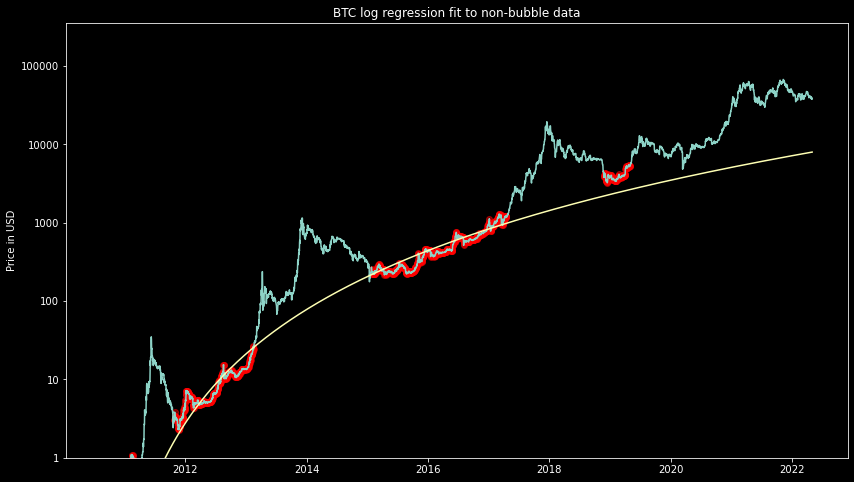

In [34]:
#we are fitting log of price of BTC against the function, not actual price
#df1 = df1.drop(df1[(df1["Age"] > 30) & (df1["Age"] < 300)].index)

df2 = df.drop(df[(df["Date"] > "2013-02-14") & (df["Date"] < "2015-01-26")].index)
df2 = df2.drop(df2[(df2["Date"] > "2011-02-17") & (df2["Date"] < "2011-10-26")].index)
df2 = df2.drop(df2[(df2["Date"] > "2017-04-17") & (df2["Date"] < "2018-11-26")].index)
df2 = df2.drop(df2[(df2["Date"] > "2019-05-01")].index)
df2 = df2.drop(df2[(df2["Date"] < "2011-02-14")].index)

ydata = np.log(df2["Value"])
#xdata = [x+1 for x in range(len(df2))] #just use numbers for dates
all_dates = df["Date"].tolist()
nb_dates = df2["Date"].tolist()
xdata = [all_dates.index(x)+1 for x in nb_dates]

popt, pcov = curve_fit(func, xdata, ydata, p0=(3.0, -10))

print(popt)
print(len(df2))


fittedYdataNonBubble = func(np.array([x+1 for x in range(len(df))]), popt[0], popt[1])#pass values to function
plt.scatter(df2["Date"], df2["Value"], c='red', alpha=0.5)
plt.style.use("dark_background")
plt.semilogy(df["Date"], df["Value"])
##############################################
ax = plt.gca()
ax.set_yscale('log')
plt.yscale('log', subsy=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(df["Date"], np.exp(fittedYdataNonBubble))
##############################################
plt.title("BTC log regression fit to non-bubble data")
plt.ylabel("Price in USD")
plt.ylim(bottom=1)
plt.show()

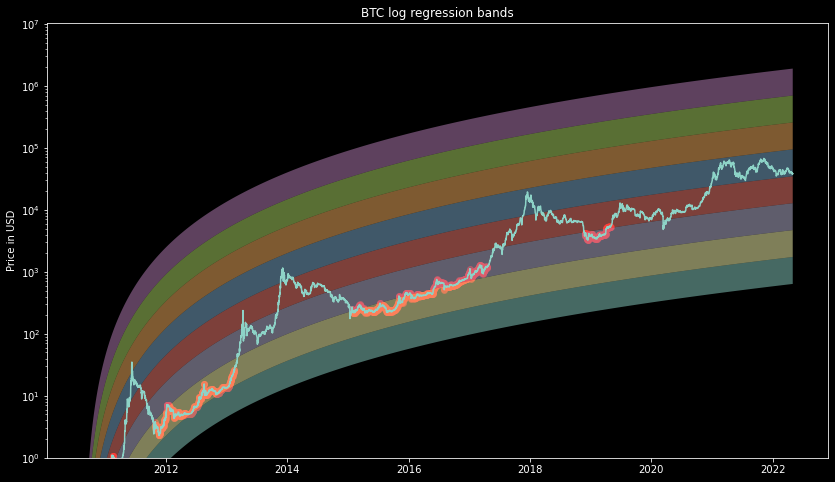

In [35]:
#plot the data

plt.style.use("dark_background")
plt.scatter(df2["Date"], df2["Value"], c='red', alpha=0.5)
plt.semilogy(df["Date"], df["Value"])
for i in range(-2,6):
    #plt.plot(df["Date"], np.exp(fittedYdata))
    plt.fill_between(df["Date"], np.exp(fittedYdata+i-1), np.exp(fittedYdata+i), alpha=0.5)
plt.ylim(bottom=1)
plt.title("BTC log regression bands")
plt.ylabel("Price in USD")
plt.show()

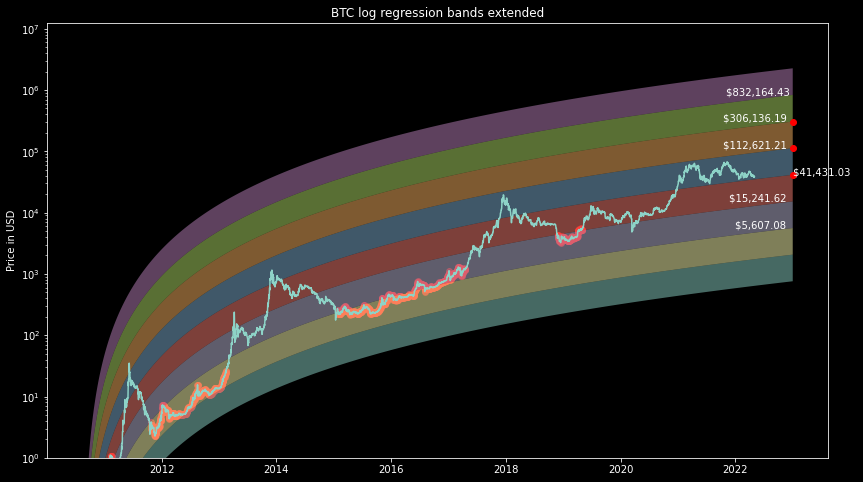

In [39]:
#extening the dates
plt.style.use("dark_background")

#first plot the price
plt.semilogy(df["Date"], df["Value"])
plt.scatter(df2["Date"], df2["Value"], c='red', alpha=0.5)
for i in range(-2,6):
    #plt.plot(df["Date"], np.exp(fittedYdata))
    plt.fill_between(extended_dates, np.exp(fittedYdataExtended+i-1), np.exp(fittedYdataExtended+i), alpha=0.5)
    
#plt.plot(extended_dates[-1], np.exp(fittedYdataExtended[-1]-1), 'ro', label = np.exp(fittedYdataExtended[-1]-1))
plt.text(extended_dates[-1], np.exp(fittedYdataExtended[-1]-1), f"${np.exp(fittedYdataExtended[-1]-1):,.2f}  ", horizontalalignment='right')
#plt.plot(extended_dates[-1], np.exp(fittedYdataExtended[-1]), 'ro')
plt.text(extended_dates[-1], np.exp(fittedYdataExtended[-1]), f"${np.exp(fittedYdataExtended[-1]):,.2f}  ", horizontalalignment='right')
plt.plot(extended_dates[-1], np.exp(fittedYdataExtended[-1]+1), 'ro')
plt.text(extended_dates[-1], np.exp(fittedYdataExtended[-1]+1), f"${np.exp(fittedYdataExtended[-1]+1):,.2f}  ", horizontalalignment='left')
plt.plot(extended_dates[-1], np.exp(fittedYdataExtended[-1]+2), 'ro')
plt.text(extended_dates[-1], np.exp(fittedYdataExtended[-1]+2), f"${np.exp(fittedYdataExtended[-1]+2):,.2f}  ", horizontalalignment='right')
plt.plot(extended_dates[-1], np.exp(fittedYdataExtended[-1]+3), 'ro')
plt.text(extended_dates[-1], np.exp(fittedYdataExtended[-1]+3), f"${np.exp(fittedYdataExtended[-1]+3):,.2f}  ", horizontalalignment='right')
#plt.plot(extended_dates[-1], np.exp(fittedYdataExtended[-1]+4), 'ro')
plt.text(extended_dates[-1], np.exp(fittedYdataExtended[-1]+4), f"${np.exp(fittedYdataExtended[-1]+4):,.2f} ", horizontalalignment='right')

plt.ylim(bottom=1)
plt.title("BTC log regression bands extended")
plt.ylabel("Price in USD")
plt.show()

In [40]:
value = np.exp(fittedYdataExtended[-1]+4)
print(f"{np.exp(fittedYdataExtended[-1]+4):,.2f}")

832,164.43


## Following section is personal scratchpad

In [41]:
data = [['tom', 10], ['nick', 15], ['juli', 14], ['juli', 142], ['juli', 134], ['juli', 414]]
df1 = pd.DataFrame(data, columns = ['Name', 'Age'])
df1

,Name,Age
0,tom,10
1,nick,15
2,juli,14
3,juli,142
4,juli,134
5,juli,414


In [453]:
df1 = df1.drop(df1[(df1["Age"] > 30) & (df1["Age"] < 300)].index).reindex()
df1


,Name,Age
0,tom,10
1,nick,15
2,juli,14
5,juli,414


In [473]:
df1["Age"].tolist().index(414)
l1 = [15,14]
df["Date"].tolist().index(df["Date"].tolist()[0])
#[df1["Age"].tolist().index(x)+1 for x in l1 ]

0

In [394]:
a = df1.index
type(list(a))
aa=list(a)
[x+1 for x in aa]

[1, 2, 3, 6]